environment: pycaret

In [6]:
#### 0. Import dependencies

In [180]:
import numpy as np 
import pandas as pd 
from pycaret.classification import *

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.style.use("ggplot")

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [2]:
df = pd.read_pickle('btcusdt_1d_ohlcv_av_1Jan2019_to_24Sep2021_1day.pkl')

In [3]:
df.columns

Index(['open_time', 'BTCUSDT_open', 'BTCUSDT_high', 'BTCUSDT_low',
       'BTCUSDT_close', 'BTCUSDT_volume', 'close_time', 'qav', 'num_trades',
       'taker_base_vol', 'taker_quote_vol', 'is_best_match', 'date',
       'usd_close', 'spy_close', 'ftse_china_close', 'gld_close', 'nfp_close',
       'btc_txn_vol', 'btc_wallet_unique', 'btc_blk_size_mb', 'year', 'month',
       'date_of_month', 'day_of_week', 'day_of_year', 'hour_of_day'],
      dtype='object')

In [4]:
# keep meaningful columns only
df = df[['BTCUSDT_open', 'BTCUSDT_high', 'BTCUSDT_low',
       'BTCUSDT_close']]

here we have high std's so we should scale our data

#### 3.0 Feature Engineering - Include Technical Analysis

In [5]:
df.columns

Index(['BTCUSDT_open', 'BTCUSDT_high', 'BTCUSDT_low', 'BTCUSDT_close'], dtype='object')

In [6]:
# Calculate the EMA10 > EMA30 signal
ema10 = df['BTCUSDT_close'].ewm(span=10).mean()
ema30 = df['BTCUSDT_close'].ewm(span=30).mean()
df['EMA10gtEMA30'] = np.where(ema10 > ema30, 1, -1)

# Calculate where Close is > EMA10
df['ClGtEMA10'] = np.where(df['BTCUSDT_close'] > ema10, 1, -1)

# Calculate the MACD signal
exp1 = df['BTCUSDT_close'].ewm(span=12).mean()
exp2 = df['BTCUSDT_close'].ewm(span=26).mean()
macd = exp1 - exp2
macd_signal = macd.ewm(span=9).mean()
df['MACD'] = macd_signal - macd

# Calculate RSI
delta = df['BTCUSDT_close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
df['RSI'] = 100 - (100/(1 + rs))

# Stochastic Oscillator
high14= df['BTCUSDT_high'].rolling(14).max()
low14 = df['BTCUSDT_low'].rolling(14).min()
df['%K'] = (df['BTCUSDT_close'] - low14)*100/(high14 - low14)

# Williams Percentage Range
df['%R'] = -100*(high14 - df['BTCUSDT_close'])/(high14 - low14)

days = 6

# Price Rate of Change
ct_n = df['BTCUSDT_close'].shift(days)
df['PROC'] = (df['BTCUSDT_close'] - ct_n)/ct_n

In [67]:
df.tail()

,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,EMA10gtEMA30,ClGtEMA10,MACD,RSI,%K,%R,PROC
1185,47241.75,47347.25,42500.00,43015.62,-1,-1,432.211471,36.911234,8.128705,-91.871295,-0.106102
1186,43016.64,43639.00,39600.00,40734.38,-1,-1,656.211800,31.780676,12.272590,-87.727410,-0.146706
1187,40734.09,44000.55,40565.39,43543.61,-1,-1,580.104609,42.398609,42.664986,-57.335014,-0.079416
1188,43546.37,44978.00,43069.09,44865.26,-1,1,413.497209,46.608929,56.963606,-43.036394,-0.070973
1189,44865.26,45200.00,43889.64,44910.53,-1,1,279.413012,46.752498,57.453371,-42.546629,-0.049347


#### 4.0 Set class labels to classify

In [68]:
# Set class labels to classify
df['return'] = df['BTCUSDT_close'].pct_change(1).shift(-1)
df['class'] = np.where(df['return'] > 0, 1, 0)

In [69]:
df['class'].value_counts() # 0= down/loss, 1=up, dataset looks pretty balanced to me 

0    655
1    535
Name: class, dtype: int64

In [70]:
#save df here to use pycaret to evaluate best classifier for the model


,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,EMA10gtEMA30,ClGtEMA10,MACD,RSI,%K,%R,PROC,return,class
0,3701.23,3810.16,3642.00,3797.14,-1,-1,0.000000,NaN,NaN,NaN,NaN,0.016175,1
1,3796.45,3882.14,3750.45,3858.56,1,1,-0.612450,100.000000,NaN,NaN,NaN,-0.023786,0
2,3857.57,3862.74,3730.00,3766.78,-1,-1,1.095222,89.690421,NaN,NaN,NaN,0.006698,1
3,3767.20,3823.64,3703.57,3792.01,-1,-1,0.846521,89.995757,NaN,NaN,NaN,0.000000,0
4,3767.20,3823.64,3703.57,3792.01,-1,-1,0.646449,89.995757,NaN,NaN,NaN,-0.005551,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,47241.75,47347.25,42500.00,43015.62,-1,-1,432.211471,36.911234,8.128705,-91.871295,-0.106102,-0.053033,0
1186,43016.64,43639.00,39600.00,40734.38,-1,-1,656.211800,31.780676,12.272590,-87.727410,-0.146706,0.068965,1
1187,40734.09,44000.55,40565.39,43543.61,-1,-1,580.104609,42.398609,42.664986,-57.335014,-0.079416,0.030352,1
1188,43546.37,44978.00,43069.09,44865.26,-1,1,413.497209,46.608929,56.963606,-43.036394,-0.070973,0.001009,1


#### 5.0 Check for NaNs and delete

In [48]:
df.isnull().sum().sum()

34

In [49]:
# check for NaNs and delete
df = df.dropna()

In [50]:
df.isnull().sum().sum()

0

In [2]:
#### 1.0 read dataframe

In [3]:
df = pd.read_csv('classification_pycaret_btcusdt_1d_ohlcv_av_1Jan2019_to_24Sep2021_1day.csv')

In [4]:
df.columns

Index(['Unnamed: 0', 'BTCUSDT_open', 'BTCUSDT_high', 'BTCUSDT_low',
       'BTCUSDT_close', 'EMA10gtEMA30', 'ClGtEMA10', 'MACD', 'RSI', '%K', '%R',
       'PROC', 'return', 'class'],
      dtype='object')

In [5]:
#### 2.0 setup pycaret environment for model evaluation to pick best model

In [6]:
df.head(1)

,Unnamed: 0,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,EMA10gtEMA30,ClGtEMA10,MACD,RSI,%K,%R,PROC,return,class
0,0,3701.23,3810.16,3642.0,3797.14,-1,-1,0.0,NaN,NaN,NaN,NaN,0.016175,1


In [47]:
clf1 = setup(data = df, 
             target = 'class',
             categorical_features = ['EMA10gtEMA30','ClGtEMA10'],
             ignore_features = ['return', 'PROC'],
             silent = True)

,Description,Value
0,session_id,1061
1,Target,class
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1190, 14)"
5,Missing Values,True
6,Numeric Features,9
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [48]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.5444,0.0000,0.1434,0.4850,0.2193,0.0217,0.0286,0.0100
lda,Linear Discriminant Analysis,0.5444,0.4986,0.1434,0.4850,0.2193,0.0217,0.0286,0.0140
lr,Logistic Regression,0.5421,0.5168,0.0425,0.2893,0.0689,-0.0015,0.0100,1.3260
qda,Quadratic Discriminant Analysis,0.5156,0.5147,0.5969,0.4747,0.5274,0.0441,0.0451,0.0120
ada,Ada Boost Classifier,0.5012,0.4702,0.3159,0.4257,0.3599,-0.0304,-0.0331,0.0780
svm,SVM - Linear Kernel,0.4975,0.0000,0.5000,0.2253,0.3106,0.0000,0.0000,0.0200
nb,Naive Bayes,0.4964,0.5195,0.6343,0.4557,0.5263,0.0152,0.0180,0.0100
gbc,Gradient Boosting Classifier,0.4735,0.4394,0.2759,0.3926,0.3225,-0.0884,-0.0907,0.1040
dt,Decision Tree Classifier,0.4711,0.4658,0.4110,0.4156,0.4130,-0.0684,-0.0685,0.0110
xgboost,Extreme Gradient Boosting,0.4638,0.4155,0.3500,0.4000,0.3720,-0.0927,-0.0929,0.4790


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=1061,
                solver='auto', tol=0.001)

In [ ]:
### here xgboost had the best accuracy score so we will use it for testing

In [ ]:
### 3.0 tune best best model by auc score

In [144]:
# creating a model
qda = create_model('qda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5238,0.5378,0.7105,0.4821,0.5745,0.0769,0.0846
1,0.5000,0.5040,0.5789,0.4583,0.5116,0.0134,0.0138
2,0.5301,0.5082,0.5263,0.4878,0.5063,0.0593,0.0594
3,0.5181,0.4924,0.5789,0.4783,0.5238,0.0449,0.0457
4,0.4699,0.4526,0.6053,0.4423,0.5111,-0.0381,-0.0404
5,0.3855,0.3661,0.4737,0.3673,0.4138,-0.2105,-0.2180
6,0.5301,0.5351,0.6842,0.4906,0.5714,0.0817,0.0873
7,0.5904,0.5635,0.6486,0.5333,0.5854,0.1881,0.1917
8,0.5181,0.5834,0.5946,0.4681,0.5238,0.0498,0.0513
9,0.5904,0.6040,0.5676,0.5385,0.5526,0.1753,0.1755


In [146]:
qda.get_params().keys()

dict_keys(['priors', 'reg_param', 'store_covariance', 'tol'])

In [150]:
# Create the parameter grid based on the results of random search 
params = {'reg_param': [0.0001, 0.1, 0.2, 0.3, 0.4, 0.5],
          'tol': [0.0001,0.0002,0.0003],
          'store_covariance': ['False', 'True']
         }
tuned_qda = tune_model(qda, n_iter = 100, custom_grid=params, optimize = 'f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5238,0.5378,0.7105,0.4821,0.5745,0.0769,0.0846
1,0.5000,0.5040,0.5789,0.4583,0.5116,0.0134,0.0138
2,0.5301,0.5082,0.5263,0.4878,0.5063,0.0593,0.0594
3,0.5181,0.4924,0.5789,0.4783,0.5238,0.0449,0.0457
4,0.4699,0.4526,0.6053,0.4423,0.5111,-0.0381,-0.0404
5,0.3855,0.3661,0.4737,0.3673,0.4138,-0.2105,-0.2180
6,0.5301,0.5351,0.6842,0.4906,0.5714,0.0817,0.0873
7,0.5904,0.5635,0.6486,0.5333,0.5854,0.1881,0.1917
8,0.5181,0.5828,0.5946,0.4681,0.5238,0.0498,0.0513
9,0.5904,0.6040,0.5676,0.5385,0.5526,0.1753,0.1755


In [151]:
#tuned model object is stored in the variable 'tuned_nb'. 
print(tuned_qda) #to see tuned hyperparameters

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0001,
                              store_covariance='False', tol=0.0001)


In [19]:
### plot models

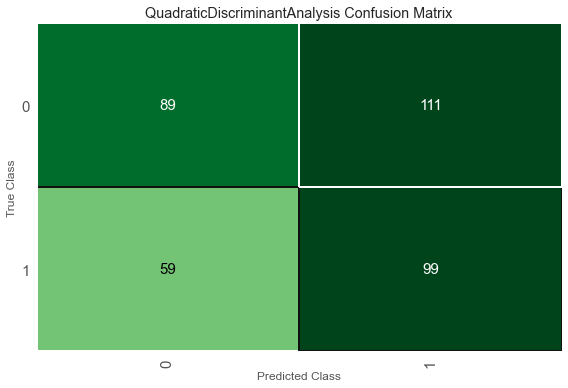

In [152]:
# plot auc for xgboost classifier
plot_model(tuned_qda, plot = 'confusion_matrix')

In [43]:
#here we see alot of false negatives and false negatives. the model is basically right about half the time. not a very good predictor

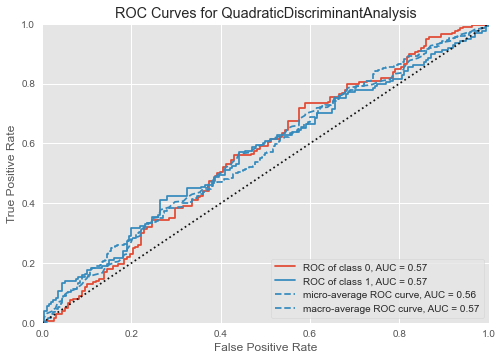

In [153]:
plot_model(tuned_qda, plot = 'auc')

In [154]:
#### evaluate model
evaluate_model(tuned_qda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [33]:
predict_model(tuned_xgb);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5391,0.4991,0.1750,0.4590,0.2534,0.0089,0.0110


In [34]:
final_classication_nb = finalize_model(tuned_lr)

In [35]:
# save model
save_model(final_classication_nb,'Final LR Model 30Sep2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['EMA10gtEMA30',
                                                             'ClGtEMA10'],
                                       display_types=False,
                                       features_todrop=['BTCUSDT_open',
                                                        'BTCUSDT_high',
                                                        'BTCUSDT_low',
                                                        'BTCUSDT_close',
                                                        'return', 'PROC'],
                                       id_columns=['Unnamed: 0'],
                                       ml_usecase='classification',
                                       numerical_features=[], target='class',
                                       time_features=[])),
                 ('imputer',
                  Simple_...
                 ('feature_select', 'passthro

In [69]:
loadmodel = load_model('Final NB Model 30Sep2021')

Transformation Pipeline and Model Successfully Loaded


In [57]:
#### Sklearn QDA

In [58]:
df.columns

Index(['Unnamed: 0', 'BTCUSDT_open', 'BTCUSDT_high', 'BTCUSDT_low',
       'BTCUSDT_close', 'EMA10gtEMA30', 'ClGtEMA10', 'MACD', 'RSI', '%K', '%R',
       'PROC', 'return', 'class'],
      dtype='object')

In [63]:
### set X, y

In [60]:
X = df[['BTCUSDT_open', 'BTCUSDT_high', 'BTCUSDT_low',
       'BTCUSDT_close', 'EMA10gtEMA30', 'ClGtEMA10', 'MACD', 'RSI', '%K', '%R']]
y = df['class']

In [164]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

In [182]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

y_prob = abc.predict_proba(X_test)[:,1]

In [169]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.93


<AxesSubplot:>

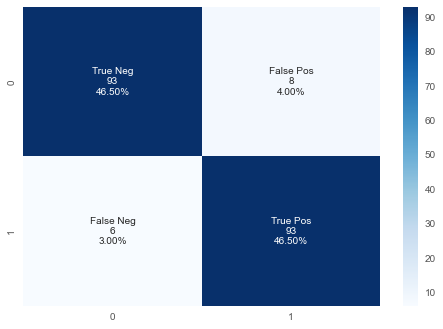

In [174]:
cf_matrix = metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cf_matrix)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Text(0.5, 0, 'False Positive Rate')

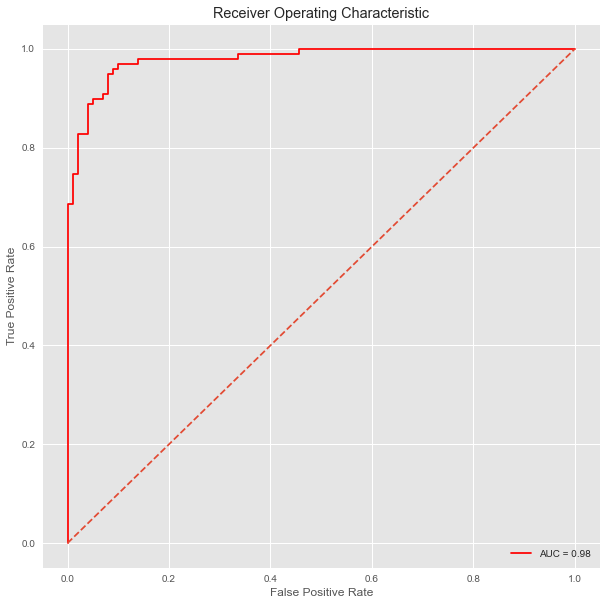

In [185]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')